## CNN_LSTM_model

## Thư viện

In [37]:
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, GlobalAveragePooling2D, Concatenate, Lambda, RepeatVector
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import tokenizer_from_json

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split

from nltk.translate.bleu_score import sentence_bleu

import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import csv
import pandas as pd
import re
import pickle
from tqdm import tqdm

## Load preprocessed captions

### Train + Val

In [38]:
df_train = pd.read_csv( '/kaggle/input/uit-viic-preprocessed/Dataset_captions/Dataset_captions/train_val_captions.csv' )

print( df_train.info() )
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18101 entries, 0 to 18100
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   image_path            18101 non-null  object
 1   caption               18101 non-null  object
 2   preprocessed_caption  18101 non-null  object
dtypes: object(3)
memory usage: 424.4+ KB
None


,image_path,caption,preprocessed_caption
0,/dataset/train/images/000000157656.jpg,Người đàn ông đang đánh tennis ngoài sân.,<start> người đàn_ông đang đánh tennis ngoài s...
1,/dataset/train/images/000000157656.jpg,Một vận động viên tennis đang vung vợt đánh bóng.,<start> một vận_động_viên tennis đang vung vợt...
2,/dataset/train/images/000000157656.jpg,Một cầu thủ tennis đang vung vợt tennis đỡ bóng.,<start> một cầu_thủ tennis đang vung vợt tenni...
3,/dataset/train/images/000000157656.jpg,Người đàn ông đang đứng ngoài biên cầm vợt sẵn...,<start> người đàn_ông đang đứng ngoài biên cầm...
4,/dataset/train/images/000000157656.jpg,Vận động viên tennis nam đang trong tư thế chu...,<start> vận_động_viên tennis nam đang trong tư...


### Test

In [39]:
df_test = pd.read_csv( '/kaggle/input/uit-viic-preprocessed/Dataset_captions/Dataset_captions/test_captions.csv' )

print( df_test.info() )
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   image_path            1155 non-null   object
 1   caption               1155 non-null   object
 2   preprocessed_caption  1155 non-null   object
dtypes: object(3)
memory usage: 27.2+ KB
None


,image_path,caption,preprocessed_caption
0,/dataset/test/images/000000205086.jpg,Một cậu bé đang chống đẩy trên quả banh.,<start> một cậu bé đang chống đẩy trên quả ban...
1,/dataset/test/images/000000205086.jpg,Một cậu bé đang chống đầu lên quả bóng đá hít ...,<start> một cậu bé đang chống đầu lên quả bóng...
2,/dataset/test/images/000000205086.jpg,Một cậu bé đang hít đất đầu trên quả banh trên...,<start> một cậu bé đang hít đất đầu trên quả b...
3,/dataset/test/images/000000205086.jpg,Một cậu bé đang hít đất cùng quả bóng và một c...,<start> một cậu bé đang hít đất cùng quả bóng ...
4,/dataset/test/images/000000205086.jpg,Một cậu bé đang chống đẩy trên một quả bóng đá.,<start> một cậu bé đang chống đẩy trên một quả...


## Plot image và caption

In [40]:
def clean_sentence( sentence ):
  sentence = re.sub(r'<[^>]+>', '', sentence)

  sentence = sentence.replace( '_', ' ' )

  sentence = sentence.strip()  # Xóa khoảng trắng thừa
  sentence = " ".join( sentence.split() ) # Xóa khoảng trắng
  return str( sentence[0].upper() + sentence[1:] + '.' )  # viết hoa chữ cái đầu tiên, thêm dấu '.'
# end

clean_sentence( '<start> trên sân_cỏ một cậu bé đang giơ chân lên để đá quả bóng <end>' )

'Trên sân cỏ một cậu bé đang giơ chân lên để đá quả bóng.'

In [41]:
def plot_image_and_caption( image_path, captions=None, true_captions=None ):
  image = np.array( Image.open( image_path ).convert('RGB') )

  plt.imshow( image )
  plt.axis('off')
  plt.show()

  if captions is not None:
    print( 'Caption:' )
    for caption in captions:
      print( '\t', caption )
    # end for

    print('-------------------------------------------------------------------')
  # end if

  if true_captions is not None:
    print( 'True caption:' )
    for true_caption in true_captions:
      print( '\t', true_caption )
    # end for
  # end if

In [42]:
data_dir = '/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/file'

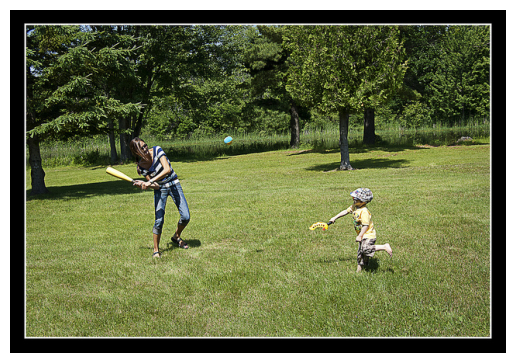

Caption:
	 <start> hình_ảnh người phụ_nữ và đứa trẻ đang chơi bóng_chày ngoài sân <end>
	 <start> người phụ_nữ đang chơi bóng_chày cùng đứa trẻ ngoài đồng_cỏ <end>
	 <start> hai người đang cùng nhau chơi bóng_chày trên đồng_cỏ <end>
	 <start> đứa trẻ ném quả bóng về phía người phụ_nữ đang cầm gậy <end>
	 <start> người phụ_nữ và đứa trẻ đang luyện_tập bóng_chày ngoài đồng_cỏ <end>
-------------------------------------------------------------------
True caption:
	 Hình ảnh người phụ nữ và đứa trẻ đang chơi bóng chày ngoài sân .
	 Người phụ nữ đang chơi bóng chày cùng đứa trẻ ngoài đồng cỏ .
	 Hai người đang cùng nhau chơi bóng chày trên đồng cỏ .
	 Đứa trẻ ném quả bóng về phía người phụ nữ đang cầm gậy .
	 Người phụ nữ và đứa trẻ đang luyện tập bóng chày ngoài đồng cỏ .


In [43]:
# prompt: randomly choose a row in dataframe

# Choose a random row index
random_index = random.randint( 0, len(df_train) - 1 )

# Get the random row
random_row = df_train.iloc[ random_index ]

# Extract the image_name as a string
image_name = random_row['image_path']

df = df_train[ df_train['image_path'] ==  image_name ]

true_captions = df['caption'].tolist()
seq = df['preprocessed_caption'].tolist()

image_path = data_dir + image_name


plot_image_and_caption( image_path, seq, true_captions )

## Load tokenizer

In [44]:
with open('/kaggle/input/uit-viic-preprocessed/Dataset_captions/Dataset_captions/tokenizer.json') as f:
    data = f.read() # Read the file content as a string.
    tokenizer = tokenizer_from_json(data)  # Pass the JSON string to tokenizer_from_json

    f.close()
#

In [45]:
vocab_size = len( tokenizer.word_index )
vocab_size

936

In [46]:
tokenizer.word_index['<pad>']

0

## Bleu score

In [47]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu4_score(reference_captions, generated_caption):
  """
  Tính điểm BLEU-4 giữa các caption tham chiếu và caption được tạo.

  Args:
    reference_captions: Danh sách các caption tham chiếu (chuỗi).
    generated_caption: Caption được tạo (chuỗi).

  Returns:
    Điểm BLEU-4 (float).
  """

  reference_tokens = [ caption.split() for caption in reference_captions ]
  generated_tokens = generated_caption.split()
  bleu4 = sentence_bleu( reference_tokens, generated_tokens, weights=(0.25, 0.25, 0.25, 0.25) )
  # Sử dụng hàm sentence_bleu với weights=(0.25, 0.25, 0.25, 0.25) để tính điểm BLEU-4.
  # Các trọng số này cho biết tầm quan trọng của unigram, bigram, trigram và 4-gram trong việc tính toán điểm.

  return bleu4

In [48]:
def bleu4_metric(y_true, y_pred):
  """
  Custom metric function for BLEU-4 score.

  Args:
    y_true: True captions (one-hot encoded).
    y_pred: Predicted captions (probabilities).

  Returns:
    BLEU-4 score (tensor).
  """

  # Convert predictions to word indices
  predicted_indices = tf.argmax( y_pred, axis=-1 )

  # Convert word indices to captions
  predicted_captions = tokenizer.sequences_to_texts( predicted_indices.numpy() )

  # Convert true captions to text
  true_captions = tokenizer.sequences_to_texts( y_true.numpy() )


  # Calculate BLEU-4 score
  bleu4_scores = []
  for i in range( len(predicted_captions) ):
    bleu4_score = sentence_bleu( [ true_captions[i].split() ], predicted_captions[i].split(), weights=(0.25, 0.25, 0.25, 0.25) )
    bleu4_scores.append( bleu4_score )

  # Return average BLEU-4 score
  return tf.reduce_mean( tf.convert_to_tensor( bleu4_scores, dtype=tf.float32 ) )

## Backbone InceptionV3

In [49]:
backbone = InceptionV3( weights='imagenet' )
backbone.trainable = False

backbone.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,851,784 (90.99 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,851,784 (90.99 MB)

In [50]:
featurer_extractor = Model( backbone.input, backbone.layers[-2].output )
featurer_extractor.summary()

del backbone

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

## Image feature extraction

In [51]:
image_path = df_train['image_path'].tolist() + df_test['image_path'].tolist()
image_path = list( set( image_path ) )
len( image_path )
#

3850

In [ ]:
# image_features = {}

# for image_name in tqdm( image_path ):
#   path = 'file' + image_name

#   # InceptionV3 expects 299x299 input
#   img = load_img( path, target_size=(299, 299) )

#   img = img_to_array( img )

#   img = img.reshape( (1, img.shape[0], img.shape[1], img.shape[2]) )

#   # Apply InceptionV3 preprocessing
#   img = inception_v3.preprocess_input( img )

#   # Extract features
#   feature = featurer_extractor.predict( img, verbose=0 )

#   # store feature
#   image_features[ image_name ] = feature

# #

# print( len( image_features ) )

In [ ]:
# print( len( image_features ) )

In [ ]:
# for key, value in image_features.items():
#   image_features[ key ] = value.astype( np.float16 )
# #

In [ ]:
# feature_array = np.array( list( image_features.values() ) )
# feature_array[0]

### Save feature

In [ ]:
# import pickle

# with open( '/content/drive/MyDrive/CS406_XLA&UD/Image_captioning_vn/Dataset_captions/image_features.pkl', 'wb' ) as f:
#   pickle.dump( image_features, f )

### Load feature from file

In [52]:
import pickle

with open( '/kaggle/input/uit-viic-preprocessed/Dataset_captions/Dataset_captions/image_features.pkl', 'rb' ) as f:
  image_features = pickle.load( f )

In [53]:
print( len( image_features ) )

feature_array = np.array( list( image_features.values() ) )
print( feature_array.shape )
feature_array[0]

3850
(3850, 1, 2048)


array([[0.291 , 0.1255, 0.555 , ..., 0.2156, 0.1783, 0.3708]],
      dtype=float16)

## Define model

In [ ]:
def CNN_LSTM_model( vocab_size, max_seq_len ):
  """
  CNN-LSTM model for image captioning.

  Args:
    vocab_size: Size of the vocabulary.
    max_seq_len: Maximum sequence length for captions.

  Returns:
    CNN-LSTM model.
  """

  # image encoder
  img_ft_input = Input( shape=( 2048, ), name='image_features' )
  img_ft = Dense( 256, activation='relu' )( img_ft_input )
  img_ft = RepeatVector( max_seq_len )( img_ft )

  # caption encoder
  caption_input = Input( shape=( max_seq_len, ), name='caption_input' )
  caption_emb = Embedding( input_dim=vocab_size, output_dim=256, mask_zero=False )( caption_input )
  caption_lstm = LSTM( 256, return_sequences=True )( caption_emb )

  # decoder
  decoder = Concatenate()( [img_ft, caption_lstm] )
  decoder = LSTM( 128, return_sequences=False )( decoder )

  fully_connected = Dense( 128, activation='relu' )( decoder )
  dropout = Dropout( 0.5 )( fully_connected )
  output = Dense( vocab_size, activation='softmax' )( dropout )

  # create model
  model = Model( inputs=[ img_ft_input, caption_input ], outputs=output )
  model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=[ 'accuracy' ] )

  return model
#

### Create model

In [54]:
# get max seq len
seq = df_train['preprocessed_caption'].tolist()
max_seq_len = max( [ len( s.split() ) for s in seq ] )
print( max_seq_len )

pad_len = (max_seq_len + 10) // 10 * 10
print( pad_len )

33
40


In [55]:
vocab_size = len( tokenizer.word_index )
vocab_size

936

In [36]:
pad_len = (max_seq_len + 10) // 10 * 10

model = CNN_LSTM_model( vocab_size, pad_len )
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_features      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ image_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 40, 256)   │    239,616 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 40, 256)   │          0 │ dense_3[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 40, 256)   │    525,312 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 40, 512)   │          0 │ repeat_vector_1[… │
│ (Concatenate)       │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    328,192 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     16,512 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 936)       │    120,744 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,754,920 (6.69 MB)

 Trainable params: 1,754,920 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

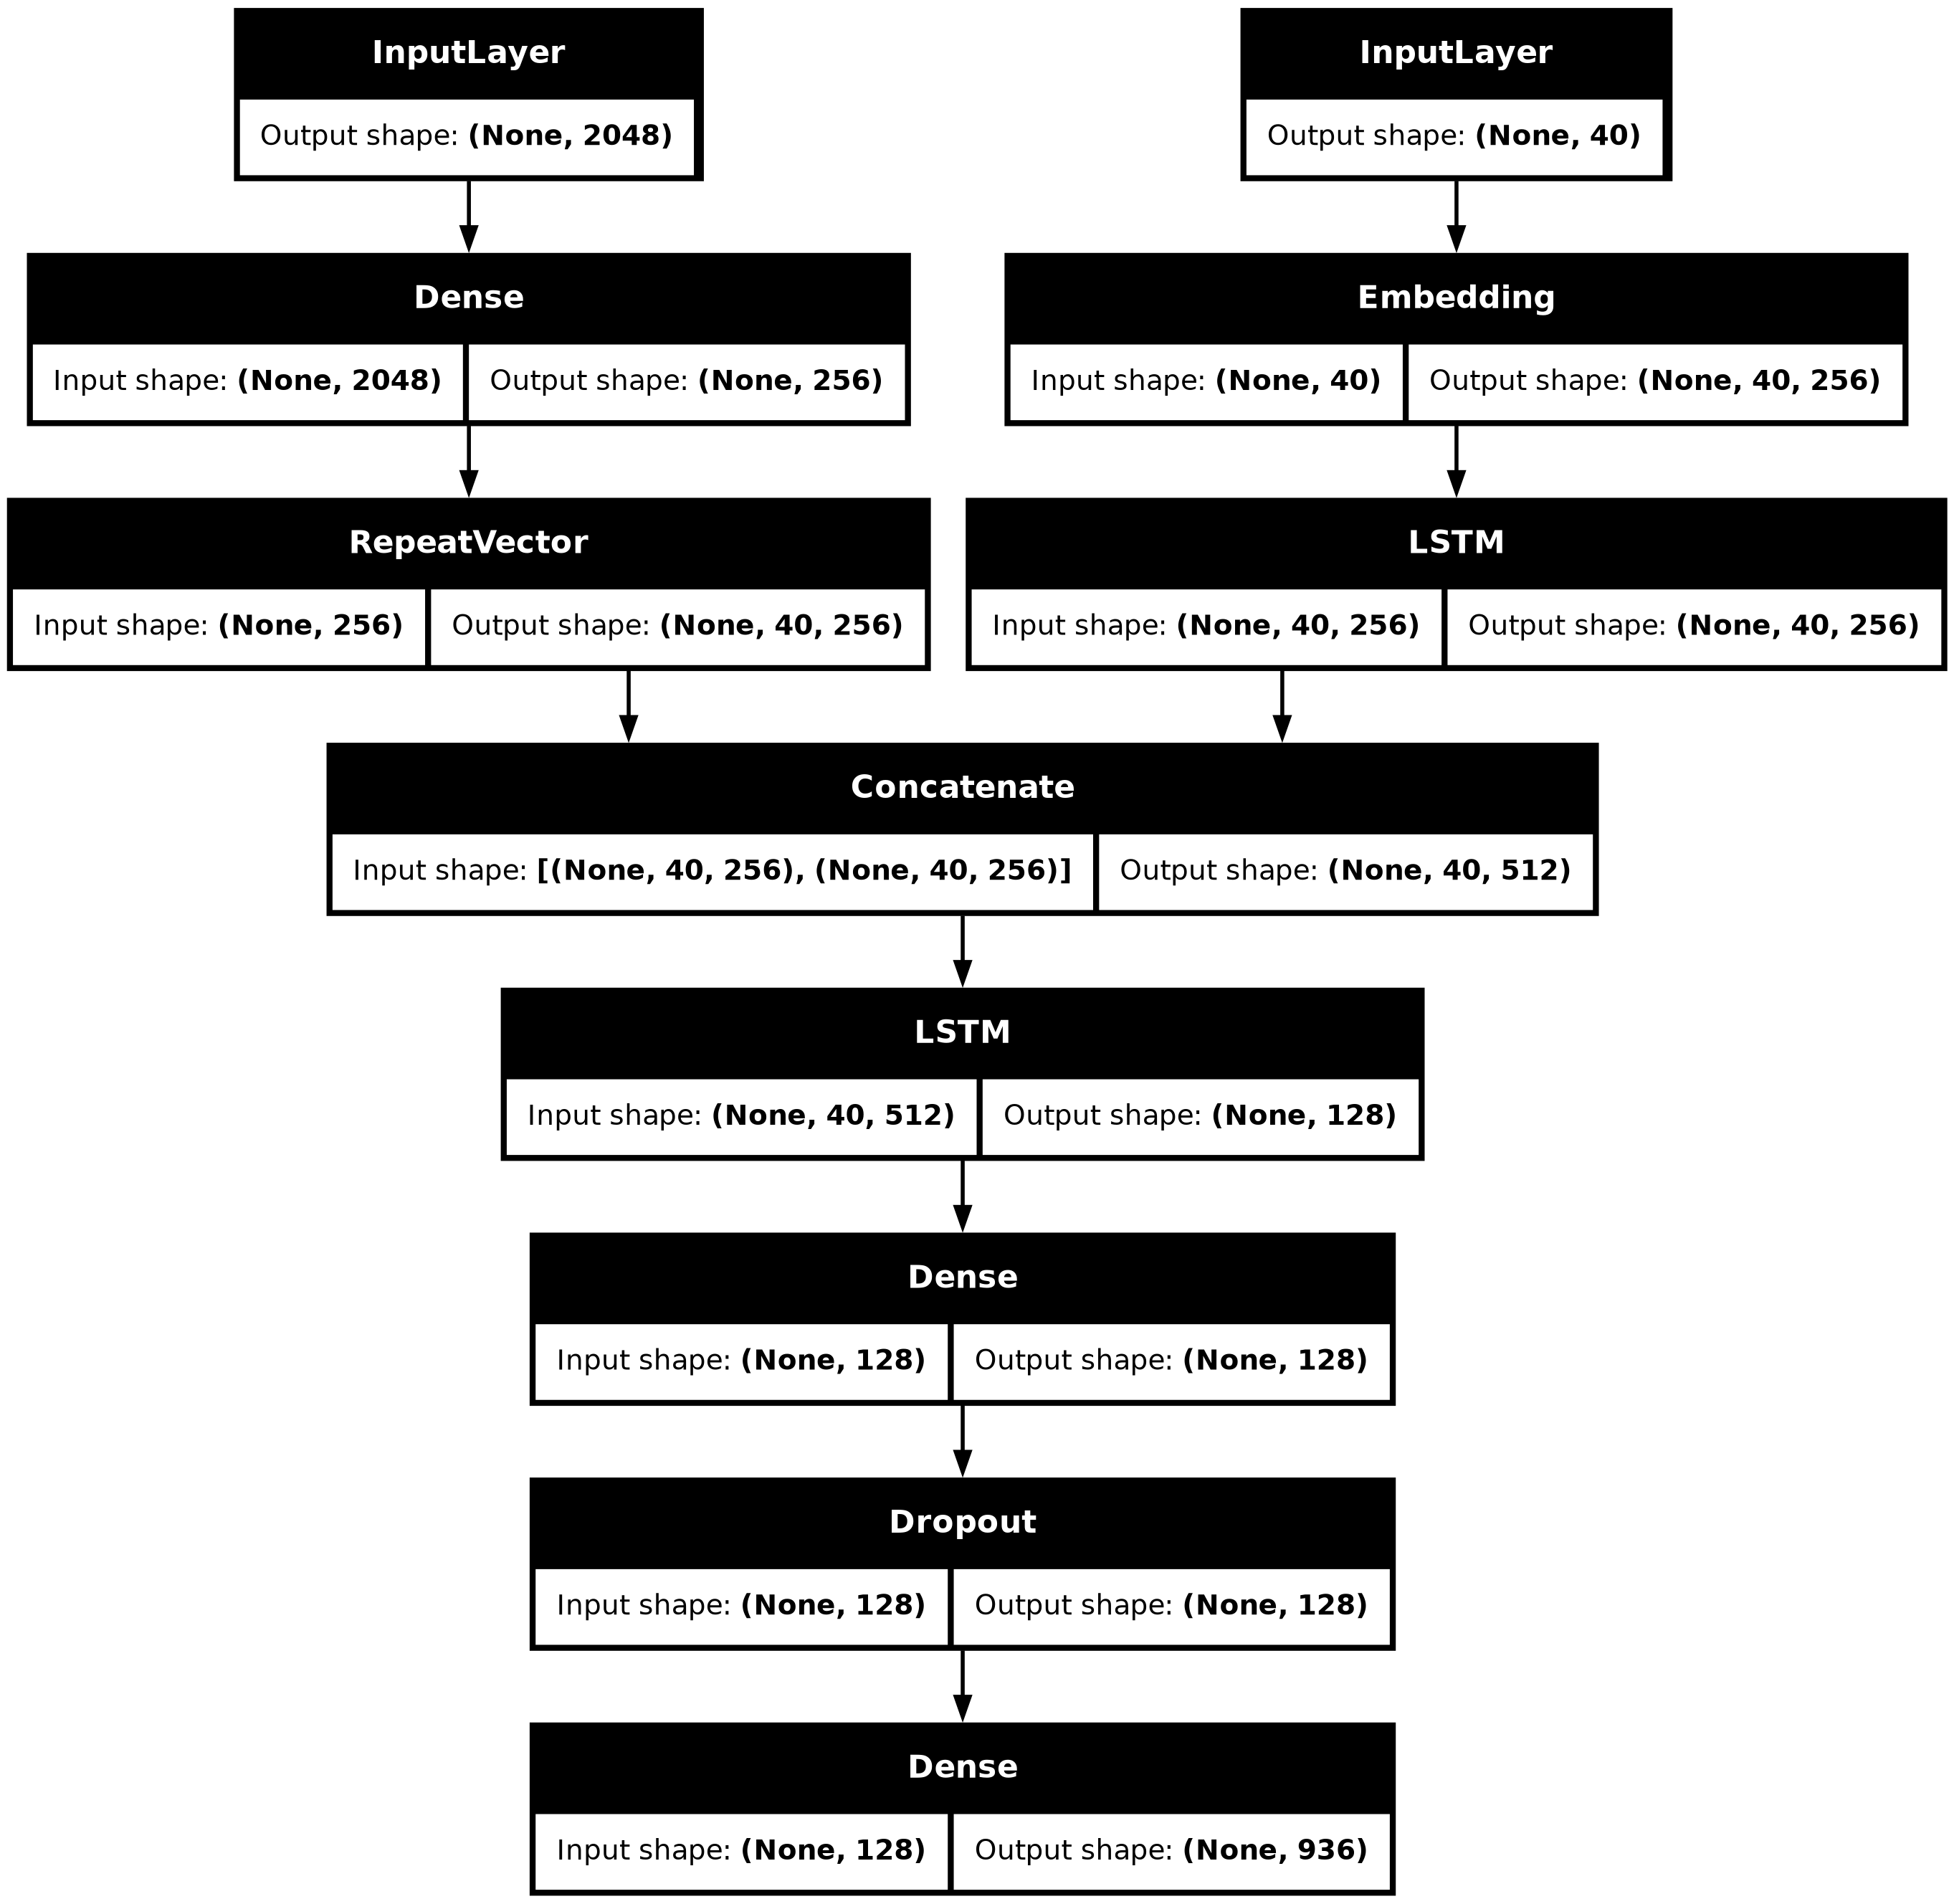

In [56]:
plot_model( model, show_shapes=True )

## Data generator

In [57]:
def data_generator( df, img_features, tokenizer, pad_len, batch_size=32, is_train=False ):
  """
  Data generator for CNN-LSTM model.
  """

  x_img, x_seq, y = list(), list(), list()
  n = 0

  while True:
    if is_train:
      df = df.sample( frac=1 )
      df.reset_index( drop=True, inplace=True )
    #

    for i, row in df.iterrows():
      n += 1

      image_name = row[ 'image_path' ]
      caption = row[ 'preprocessed_caption' ]

      # get image feature
      img_feature = img_features[ image_name ][0]

      # process caption
      seq = tokenizer.texts_to_sequences( [ caption ] )[0]

      # chia seq thành input, output
      for i in range( 1, len( seq ) ):
        in_seq, out_seq = seq[:i], seq[i]

        # pad input sequence
        in_seq = pad_sequences( [in_seq], maxlen=pad_len, padding='pre' )[0]

        # encode output seq
        out_seq = to_categorical( [out_seq], num_classes=len( tokenizer.word_index ) )[0]

        # add to data list
        x_img.append( img_feature )
        x_seq.append( in_seq )
        y.append( out_seq )
      # end for

      # batch size reached
      if n == batch_size:
        # Convert to NumPy arrays with correct data types
        x_img = np.array( x_img, dtype=np.float16 )
        x_seq = np.array( x_seq, dtype=np.int16 )
        y = np.array( y, dtype=np.float16 )

        yield ( x_img, x_seq ), y

        # reset
        x_img, x_seq, y = list(), list(), list()
        n = 0
      #
# end def

# Define the output signature for the generator
output_signature = (
    (
        tf.TensorSpec( shape=(None, 2048), dtype=tf.float16 ),  # x_img
        tf.TensorSpec( shape=(None, pad_len), dtype=tf.int16 )  # x_seq
    ),
    tf.TensorSpec( shape=(None, vocab_size), dtype=tf.float16 )  # y
)

### Train val split

In [58]:
df_train_, df_val = train_test_split( df_train, test_size=0.15, random_state=42 )
print( df_train_.shape )
print( df_val.shape )

(15385, 3)
(2716, 3)


### Create data generator

In [59]:
pad_len

40

In [60]:
batch_size = 128

train_steps = len( df_train_ ) // batch_size
val_steps = len( df_val ) // batch_size

print( train_steps )
print( val_steps )

train_generator = tf.data.Dataset.from_generator(
    lambda: data_generator(df_train_, image_features, tokenizer, pad_len, batch_size, is_train=True),
    output_signature=output_signature
)

val_generator = tf.data.Dataset.from_generator(
    lambda: data_generator(df_val, image_features, tokenizer, pad_len, batch_size),
    output_signature=output_signature
)

120
21


## Train model

#### Create Directory for Saving

In [61]:
save_dir = os.path.join( '/kaggle/working/Do_an_image_captioning_vn_model', 'CNN_LSTM_best_model' )
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

#### Create Callbacks

In [62]:
filepath = os.path.join( save_dir, 'CNN_LSTM_best_model.keras' )

checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    save_weights_only=False,  # Save the entire model, not just weights
    mode='min',  # Save when validation loss is minimized
    save_freq='epoch',  # Save at the end of each epoch
)

early_stopping = EarlyStopping( monitor='val_loss', patience=5 ) # Stop if val_loss doesn't improve

## Load model

In [63]:
model = load_model( '/kaggle/input/cs406_cs331_image_captioning_vn_cnn_lstm_model/tensorflow2/default/1/CNN_LSTM_best_model/CNN_LSTM_best_model/CNN_LSTM_best_model.keras' )
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_features      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ image_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 40, 256)   │    239,616 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 40, 256)   │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 40, 256)   │    525,312 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 40, 512)   │          0 │ repeat_vector_4[… │
│ (Concatenate)       │                   │            │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 128)       │    328,192 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     16,512 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 936)       │    120,744 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,264,762 (20.08 MB)

 Trainable params: 1,754,920 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,509,842 (13.39 MB)

#### Train the Model

In [65]:
num_epochs = 100

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = num_epochs,
    validation_data = val_generator,
    validation_steps = val_steps,
    callbacks = [ checkpoint ]
)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.6862 - loss: 1.1582 - val_accuracy: 0.6723 - val_loss: 1.3290
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.6906 - loss: 1.1318 - val_accuracy: 0.6741 - val_loss: 1.3205
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.6907 - loss: 1.1322 - val_accuracy: 0.6712 - val_loss: 1.3349
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.6908 - loss: 1.1308 - val_accuracy: 0.6746 - val_loss: 1.3329
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 0.6885 - loss: 1.1356 - val_accuracy: 0.6739 - val_loss: 1.3240
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.6922 - loss: 1.1301 - val_accuracy: 0.6752 - val_loss: 1.3298
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.6954 - loss: 1.1098 - val_accuracy: 0.6745 - val_loss: 1.3274
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.6957 -

#### Load the Best Model

In [74]:
# from tensorflow.keras.models import load_model

best_model = load_model( '/kaggle/working/Do_an_image_captioning_vn_model/CNN_LSTM_best_model/CNN_LSTM_best_model.keras' )

In [75]:
best_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_features      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ image_features[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 40, 256)   │    239,616 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 40, 256)   │          0 │ dense_12[0][0]    │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 40, 256)   │    525,312 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 40, 512)   │          0 │ repeat_vector_4[… │
│ (Concatenate)       │                   │            │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 128)       │    328,192 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     16,512 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 936)       │    120,744 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,264,762 (20.08 MB)

 Trainable params: 1,754,920 (6.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,509,842 (13.39 MB)

In [76]:
batch_size = 128

test_steps = len( df_test ) // batch_size
print( test_steps )

test_generator = tf.data.Dataset.from_generator(
    lambda: data_generator( df_test, image_features, tokenizer, pad_len, batch_size ),
    output_signature=output_signature
)

best_model.evaluate( test_generator, steps=test_steps )

9
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6030 - loss: 1.8073


[1.6874151229858398, 0.6183951497077942]

### Continue training

In [70]:
num_epochs = 100

history = best_model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = num_epochs,
    validation_data = val_generator,
    validation_steps = val_steps,
    callbacks = [ checkpoint ]  # Include both callbacks
)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.6890 - loss: 1.1455 - val_accuracy: 0.6752 - val_loss: 1.3196
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - accuracy: 0.6903 - loss: 1.1367 - val_accuracy: 0.6750 - val_loss: 1.3178
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step - accuracy: 0.6914 - loss: 1.1282 - val_accuracy: 0.6737 - val_loss: 1.3370
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.6925 - loss: 1.1308 - val_accuracy: 0.6763 - val_loss: 1.3247
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 0.6955 - loss: 1.1119 - val_accuracy: 0.6770 - val_loss: 1.3143
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 0.6958 - loss: 1.1078 - val_accuracy: 0.6764 - val_loss: 1.3247
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 0.6981 - loss: 1.0977 - val_accuracy: 0.6749 - val_loss: 1.3459
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 0.6973 -

## Generate caption

In [77]:
def generate_caption( image_path, model, featurer_extractor, tokenizer, pad_len ):
  """
  Generate a caption for an image using a CNN-LSTM model.

  Args:
    image_path: Path to the image file.
    model: CNN-LSTM model.
    featurer_extractor: Feature extractor model.
    tokenizer: Tokenizer.
    pad_len: Length of the input sequence.

  Returns:
    Generated caption.
  """

  # extract image feature
  img = load_img( image_path, target_size=(299, 299) )
  img = img_to_array( img )
  img = img.reshape( (1, img.shape[0], img.shape[1], img.shape[2]) )

  # Apply InceptionV3 preprocessing
  img = inception_v3.preprocess_input( img )

  # Extract features
  feature = featurer_extractor.predict( img, verbose=0 )

  #
  seed_text = '<start>'

  while True:
    seed_seq = tokenizer.texts_to_sequences( [ seed_text ] )[0]
    seed_seq = pad_sequences( [seed_seq], maxlen=pad_len, padding='pre' )

    y_pred = model.predict( [ feature, seed_seq ], verbose=0 )
    y_pred = np.argmax( y_pred )

    word = tokenizer.index_word[ y_pred ]
    seed_text += ' ' + word

    if word == '<end>':
      break
  # end while

  return seed_text

In [78]:
pad_len

40

In [79]:
idx = 105

img_name = df_test['image_path'].tolist()[idx]
img_path = data_dir + img_name
print( img_path )

caption = generate_caption( img_path, best_model, featurer_extractor, tokenizer, pad_len )
print( caption )

/kaggle/input/uit-viic-v1-0-vietnamese-image-captioning/file/dataset/test/images/000000085876.jpg


I0000 00:00:1732963210.001650     101 service.cc:145] XLA service 0x56e012951d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732963210.001705     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732963210.001711     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732963215.905266     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


<start> một người đàn_ông đang chuẩn_bị đánh_quả bóng tennis <end>


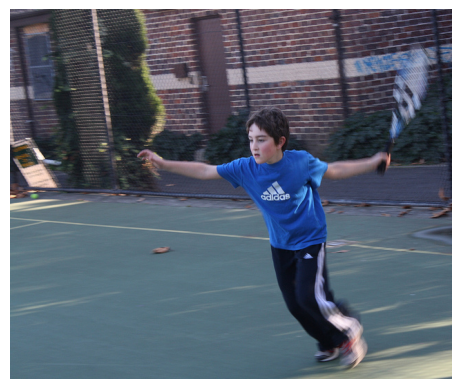

Caption:
	 Một người đàn ông đang chuẩn bị đánh quả bóng tennis.
-------------------------------------------------------------------
True caption:
	 Một cậu bé đang đứng cầm vợt tennis bằng tay trái ở trên sân .
	 Một cậu bé đang giơ vợt lên cao ở trên sân tennis .
	 Một cậu bé đang đứng vung vợt ở trên sân tennis .
	 Một cậu bé đang đưa vợt ra sau để chuẩn bị đánh bóng .
	 Một cậu bé đang luyện tập tennis ở trên sân .


In [80]:
caption = [ clean_sentence( caption ) ]

true_captions = df_test[ df_test['image_path'] == img_name ]['caption'].tolist()

plot_image_and_caption( img_path, caption, true_captions )